In [1]:
import $file.scripts.importer

importer.loadProjectDependencies

import $file.$               



In [2]:
import scala.collection.JavaConverters._
import scala.collection.JavaConversions._
import edu.stanford.math.plex4._
import edu.stanford.math.plex4.api._
import edu.stanford.math.plex4.visualization._
import edu.stanford.math.plex4.homology.barcodes._

import breeze.numerics._
import breeze.linalg._
import breeze.math._
import breeze.stats.{mean, stddev}
import breeze.util.JavaArrayOps

import tda.persistence.Analysis._
import tda.persistence.Math

implicit def mapEntryAsTuple[T,S](me: java.util.Map.Entry[T,S]): (T,S) = {
  (me.getKey(), me.getValue)
}

def drawBarcodes(images: Seq[java.awt.image.BufferedImage]) = {
  images foreach publish.png 
}


import scala.collection.JavaConverters._

import scala.collection.JavaConversions._

import edu.stanford.math.plex4._

import edu.stanford.math.plex4.api._

import edu.stanford.math.plex4.visualization._

import edu.stanford.math.plex4.homology.barcodes._


import breeze.numerics._

import breeze.linalg._

import breeze.math._

import breeze.stats.{mean, stddev}

import breeze.util.JavaArrayOps


import tda.persistence.Analysis._

import tda.persistence.Math


defined function mapEntryAsTuple
defined function drawBarcodes

In [3]:
lazy val stream = Plex4.createExplicitSimplexStream()

stream.addVertex(0)
stream.addVertex(1)
stream.addVertex(2)
stream.addElement(Array(0, 1))
stream.addElement(Array(0, 2))
stream.addElement(Array(1,2))
stream.finalizeStream()

stream.getSize

stream: streams.impl.ExplicitSimplexStream = <lazy>
res2_8: Int = 6

In [4]:
lazy val persistence = Plex4.getModularSimplicialAlgorithm(3, 2)
lazy val circleIntervals = persistence.computeIndexIntervals(stream)

persistence: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>
circleIntervals: BarcodeCollection[Integer] = <lazy>

## 9 - sphere 

In [5]:
lazy val dimension = 9
lazy val stream = Plex4.createExplicitSimplexStream()
stream.addElement(0 to (dimension + 1) toArray)
stream.ensureAllFaces()
stream.removeElementIfPresent(0 to (dimension + 1) toArray)
stream.finalizeStream()

lazy val persistence9 = Plex4.getModularSimplicialAlgorithm(dimension + 1, 2)

dimension: Int = <lazy>
stream: streams.impl.ExplicitSimplexStream = <lazy>
res4_4: Boolean = true
persistence9: homology.interfaces.AbstractPersistenceAlgorithm[homology.chain_basis.Simplex] = <lazy>

In [20]:
lazy val intervals9 = persistence.computeIntervals(stream)

intervals9: BarcodeCollection[java.lang.Double] = <lazy>

# House

![](https://github.com/appliedtopology/javaplex/raw/master/reports/javaplex_tutorial/houseFig.png)

### Explicit stream

In [7]:
lazy val houseStream = Plex4.createExplicitSimplexStream();
houseStream.addVertex(1, 0);
houseStream.addVertex(2, 0);
houseStream.addVertex(3, 0);
houseStream.addVertex(4, 0);
houseStream.addVertex(5, 1);
houseStream.addElement(Array(1, 2), 0);
houseStream.addElement(Array(2,3), 0);
houseStream.addElement(Array(3, 4), 0);
houseStream.addElement(Array(4, 1), 0);
houseStream.addElement(Array(3, 5), 2);
houseStream.addElement(Array(4, 5), 3);
houseStream.addElement(Array(3, 4, 5), 7);
houseStream.finalizeStream()

houseStream: streams.impl.ExplicitSimplexStream = <lazy>

In [8]:
lazy val intervals = persistence.computeIntervals(houseStream)
lazy val actualIntervals = intervals.getIntervalIterator.asScala.map(_.getValue).toList
actualIntervals.length

intervals: BarcodeCollection[java.lang.Double] = <lazy>
actualIntervals: List[java.util.List[Interval[java.lang.Double]]] = <lazy>
res7_2: Int = 2

In [9]:
lazy val intervalsDim0 = BarcodeUtility.getEndpoints(intervals, 1, false)

intervalsDim0: Array[Array[Double]] = <lazy>

### Vietoris-Rips from point cloud

In [10]:
lazy val pointCloud = examples.PointCloudExamples.getHouseExample()
lazy val houseMetricSpace= new metric.impl.EuclideanMetricSpace(pointCloud)

lazy val (maxDimension, maxFiltrationValue, numDivisions)= (3, 4.0, 100)

lazy val vietorisRipsStream = api.Plex4.createVietorisRipsStream(
  houseMetricSpace,
  maxDimension,
  maxFiltrationValue,
  numDivisions)


lazy val (_, houseImgs) = intervalsWithImages(vietorisRipsStream, maxDimension, maxFiltrationValue, persistence)

pointCloud: Array[Array[Double]] = <lazy>
houseMetricSpace: metric.impl.EuclideanMetricSpace = <lazy>
maxDimension: Int = <lazy>
maxFiltrationValue: Double = <lazy>
numDivisions: Int = <lazy>
vietorisRipsStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
houseImgs: List[java.awt.image.BufferedImage] = <lazy>

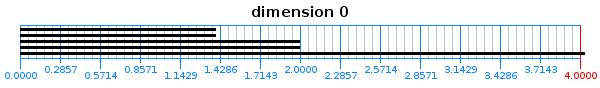

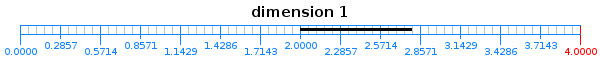

In [11]:
drawBarcodes(houseImgs)

## Torus homology 

In [12]:
lazy val torusData = csvread(importer.loadData("pointsTorusGrid.csv"))

lazy val torusDataArray = JavaArrayOps.dmDToArray2(torusData)

lazy val (maxDimension, maxFiltrationValue, numDivisions) = (3, 0.9, 100)

lazy val torusStream = Plex4.createVietorisRipsStream(torusDataArray, maxDimension, maxFiltrationValue, numDivisions)

lazy val (_, torusImages) = intervalsWithImages(torusStream, maxDimension, maxFiltrationValue, persistence)

torusData: DenseMatrix[Double] = <lazy>
torusDataArray: Array[Array[Double]] = <lazy>
maxDimension: Int = <lazy>
maxFiltrationValue: Double = <lazy>
numDivisions: Int = <lazy>
torusStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
torusImages: List[java.awt.image.BufferedImage] = <lazy>

In [13]:
println(Seq(
  "TorusStream for",
  s"maxFiltrationValue = ${maxFiltrationValue}",
  s"has ${torusStream.getSize()} simplices").mkString("\n"))

TorusStream for
maxFiltrationValue = 0.9
has 82479 simplices


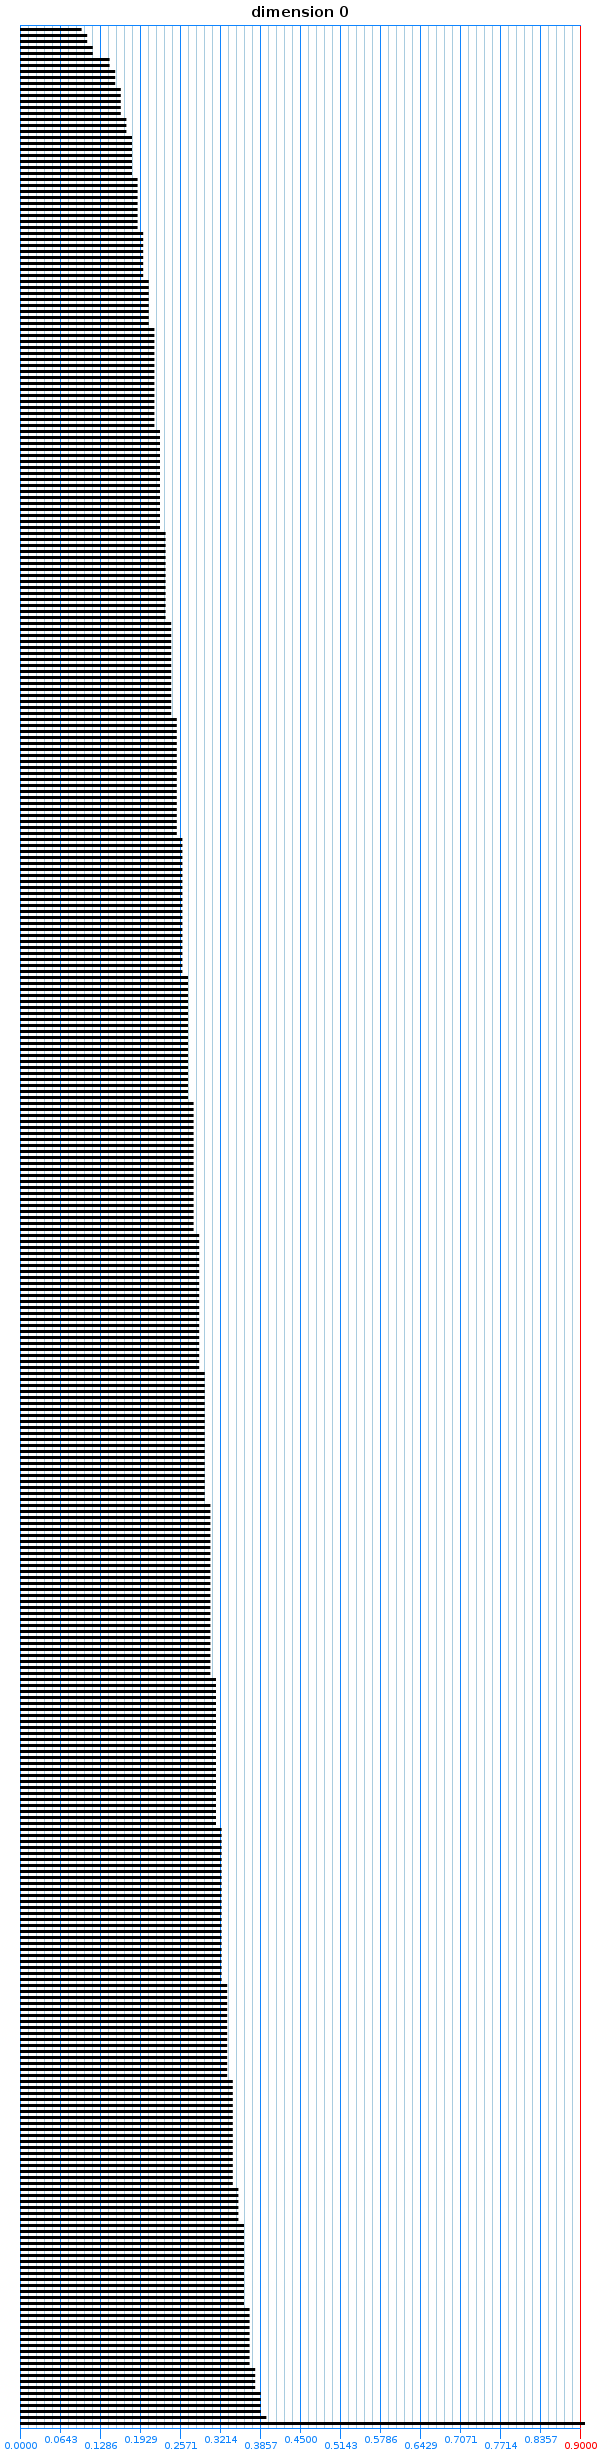

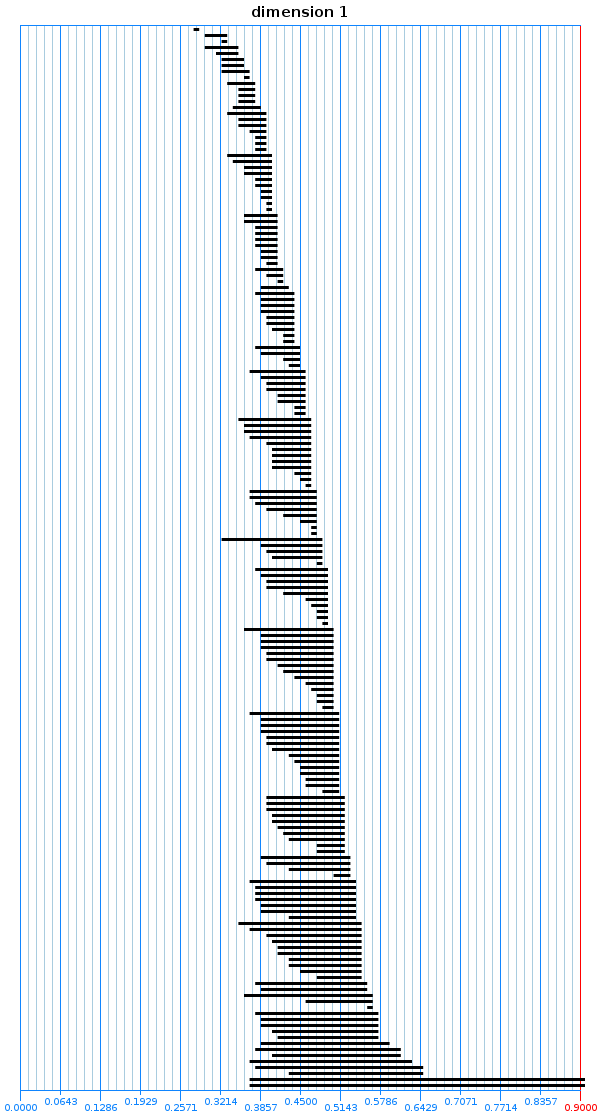

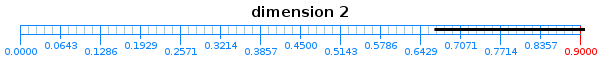

In [14]:
drawBarcodes(torusImages)

## Torus homology with landmarks 

We select 50 samples using sequential maxmin.

```
sequentialMaxMin(X, N)
    L = {}
    pick random l0 from X
    L = {l0}
    while L's size < N
        l = argmax d(x, L)
        add l to L
    return L
```

In [25]:
lazy val noLandmarkPoints = 50 


noLandmarkPoints: Int = <lazy>

In [26]:
lazy val landmarkIndices = Plex4
  .createMaxMinSelector(torusDataArray, noLandmarkPoints)
  .getLandmarkPoints()

lazy val torusLandmarks = landmarkIndices.map(torusDataArray(_))

lazy val torusLandmarksStream = Plex4.createVietorisRipsStream(torusLandmarks, maxDimension, landmarkMaxFiltrationValue, numDivisions)

lazy val (_, toruslandmarkImages) = intervalsWithImages(torusLandmarksStream, maxDimension, landmarkMaxFiltrationValue, persistence)

landmarkIndices: Array[Int] = <lazy>
torusLandmarks: Array[Array[Double]] = <lazy>
torusLandmarksStream: streams.impl.VietorisRipsStream[Array[Double]] = <lazy>
toruslandmarkImages: List[java.awt.image.BufferedImage] = <lazy>

In [30]:
println(Seq(
  s"LandmarksTorusStream for ${torusLandmarks.size} landmarks",
  s"landmarkMaxFiltrationValue = ${landmarkMaxFiltrationValue} = ${landmarkMaxFiltrationValue / maxFiltrationValue} * maxFiltrationValue",
  s"has ${torusLandmarksStream.getSize()} simplices",
  s"(${torusStream.getSize() / torusLandmarksStream.getSize()}x less than original stream)").mkString("\n"))

LandmarksTorusStream for 50 landmarks
landmarkMaxFiltrationValue = 1.8 = 2.0 * maxFiltrationValue
has 2604 simplices
(31x less than original stream)


As we can see, landmark complex has order of magnitude less simplices.

Comparing barcodes of original and reduced complex we see that landmark complex has less small intervals, but true torus intervals are present - sampling by maxmin can be thought as a denoising procedure.

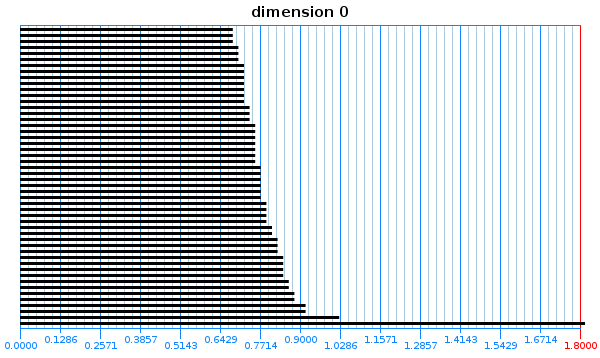

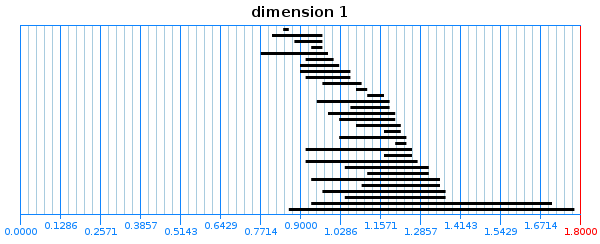

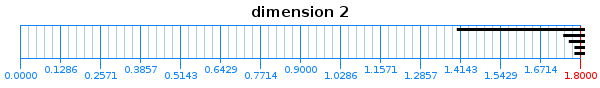

In [29]:
drawBarcodes(toruslandmarkImages)